In [42]:
import mne
import matplotlib.pyplot as plt
import numpy as np 
import os
from itertools import chain
from scipy.fft import fft, fftfreq
from fooof import FOOOF

In [ ]:
def process_eeg_files(folder_path):
    y_frequencies_dict = {}
    
    # Loop over all .set files in the folder
    for filename in os.listdir(folder_path):
        if filename.endswith('.set'):
            file_path = os.path.join(folder_path, filename)
            raw_eeg = mne.io.read_raw_eeglab(file_path, preload=True)
            
            # Preprocess the raw EEG data
            raw_eeg = preprocess_raw_eeg(raw_eeg)
            
            # Extract and modify events
            events, event_id = extract_and_modify_events(raw_eeg)
            
            # Create epochs
            epochs = create_epochs(raw_eeg, events, event_id)

            conditions = ['frequent_rare', 'rare_frequent', 'frequent_frequent']
            
            y_frequencies_dict[filename.split('.')[0]] = {}
            for condition in conditions: 

                # Separate epochs into pre and post-stimulus windows
                epochs_pre, epochs_post = separate_epochs(epochs[condition])

                assert len(epochs_pre) == len(epochs_post)
                
                # Perform FFT on the Pz channel data
                yf_avg_pre, yf_avg_post = perform_fft_on_epochs(epochs_pre, epochs_post)
                
                xf = get_xf(epochs_pre)

                assert yf_avg_pre.shape == xf.shape 

                #Compute ERP for condition
                erp = compute_erp(epochs_post[condition])

                #Compute FFT for ERP
                fft_erp = perform_fft_on_erp(erp)
                
                xf_erp = get_xf(erp)
                
                assert fft_erp.shape == xf_erp.shape

                #subtracting the erp  from the post event data for each candidate
                post_minus_erp = yf_avg_post - fft_erp

                power_spec_windows = [ yf_avg_pre, yf_avg_post, post_minus_erp]
                results = []
                for power_spec in power_spec_windows:
                
                    fg = FOOOF(
                        #had to modify peak width limits because using different time series data then gyurkovics
                            peak_width_limits=[2.5, 8],
                            max_n_peaks= 1,
                            min_peak_height=0.3,
                            peak_threshold=2.0,
                            aperiodic_mode='fixed'
                        )

                    #the parameters for fit are frequency data of the power spectra (xf) and frequency (yf_avg) 
                    #frequency range from gyurkovics defined a as >2 hz but <25hz
                    fg.fit(xf, yf_avg_pre, freq_range= (2,25))

                    aps = fg.get_params('aperiodic_params')
                    rsq = fg.get_params('r_squared')
                    results.append([power_spec, aps, rsq])

                results = results + [fft_erp, xf, xf_erp]
                # Update the dictionary with the results
                y_frequencies_dict[filename.split('.')[0]][condition] = results
    
    return y_frequencies_dict

def preprocess_raw_eeg(raw_eeg):
    """
    Preprocess the raw EEG data by setting the montage, renaming channels, and setting channel types.
    """
    # Set standard 10-20 montage
    montage = mne.channels.make_standard_montage('standard_1020')
    raw_eeg.rename_channels({"FP1": 'Fp1', 'FP2': 'Fp2'})
    raw_eeg.set_channel_types({
        'HEOG_left': 'eog', 'HEOG_right': 'eog',
        'VEOG_lower': 'eog', '(uncorr) HEOG': 'eog',
        '(uncorr) VEOG': 'eog'
    })
    raw_eeg.set_montage(montage)
    return raw_eeg

def extract_and_modify_events(raw_eeg):
    """
    Extract events from annotations and modify event IDs according to specific conditions.
    """
    events, _ = mne.events_from_annotations(raw_eeg)
    
    # Remove events with IDs 6 and 7
    events = events[~np.isin(events[:, 2], [6, 7])]
    
    # Define target and non-target event IDs
    target_ids = [1, 9, 15, 21, 27]
    nontarget_ids = [2, 3, 4, 5, 8, 10, 11, 12, 13, 14,
                     16, 17, 18, 19, 20, 22, 23, 24, 25, 26]
    
    # Modify event IDs based on conditions
    for i in range(len(events)):
        current_id = events[i, 2]
        if current_id in target_ids:
            events[i, 2] = 100  # 'frequent_rare'
        elif (i > 0 and current_id in nontarget_ids and
              events[i - 1, 2] == 100):
            events[i, 2] = 200  # 'rare_frequent'
        elif (i > 0 and current_id in nontarget_ids and
              events[i - 1, 2] in [200, 300]):
            events[i, 2] = 300  # 'frequent_frequent'
    
    # Define new event IDs
    event_id = {
        "frequent_rare": 100,
        "rare_frequent": 200,
        "frequent_frequent": 300
    }
    return events, event_id

def create_epochs(raw_eeg, events, event_id):
    """
    Create epochs from the raw EEG data using the modified events.
    """
    epochs = mne.Epochs(
        raw_eeg, events=events, event_id=event_id,
        tmin=-0.6, tmax=0.6, picks=['Pz'],
        baseline=None, preload=True
    )
    return epochs

def separate_epochs(epochs):
    """
    Separate epochs into pre-stimulus and post-stimulus windows.
    """
    epochs_pre = epochs.copy().crop(tmin=-0.6, tmax=0)
    epochs_post = epochs.copy().crop(tmin=0, tmax=0.6)
    return epochs_pre, epochs_post

def perform_fft_on_epochs(epochs_pre, epochs_post):
    """
    Perform FFT on the Pz channel data of pre and post-stimulus epochs.
    """
    # Extract Pz channel data
    pre_data = epochs_pre.copy().pick(['Pz']).get_data()
    post_data = epochs_post.copy().pick(['Pz']).get_data()
    
    # Average over epochs
    pre_data_mean = pre_data.mean(axis=0)[0]
    post_data_mean = post_data.mean(axis=0)[0]
    
    # Perform FFT
    yf_avg_pre = np.abs(fft(pre_data_mean))
    yf_avg_post = np.abs(fft(post_data_mean))
    return yf_avg_pre, yf_avg_post

def compute_erp(epochs_post): 
    erp = epochs_post.average() 
    return erp

def perform_fft_on_erp(erp):
    data = erp.pick(['Pz']).get_data()
    print(data.shape)
    erp_mean = data.mean(axis=0)
    print(erp_mean.shape)
    erp_avg =  np.abs(fft(erp_mean))
    return erp_avg


def get_xf(epoch_window):

    # Getting the sampling frequency
    sample_rate = epoch_window.info['sfreq']

    # Acessing the num of epochs, channels, and time points
    data = epoch_window.get_data()

    #N is required for xf calculations
    N = data.shape[-1]

    xf = fftfreq(N, 1/sample_rate)
    return xf

if __name__ == '__main__':
    folder_path = "C:/Users/leofl/OneDrive/Desktop/ERP Data/Project Cygnus/"
    y_frequencies_dict = process_eeg_files(folder_path)
    # Now y_frequencies_dict contains the FFT results for each file


In [41]:
y_frequencies_dict['p3_1']['frequent_frequent'][0].shape

(155,)

In [12]:
print(len(y_frequencies_dict['p3_1']['frequent_frequent'][0]))
print(len(y_frequencies_dict['p3_1']['frequent_frequent'][1]))
print(len(y_frequencies_dict['p3_1']['frequent_frequent'][2]))
print(len(y_frequencies_dict['p3_1']['frequent_frequent'][3]))
print(len(y_frequencies_dict['p3_1']['frequent_frequent'][4]))

155
155
309
155
309


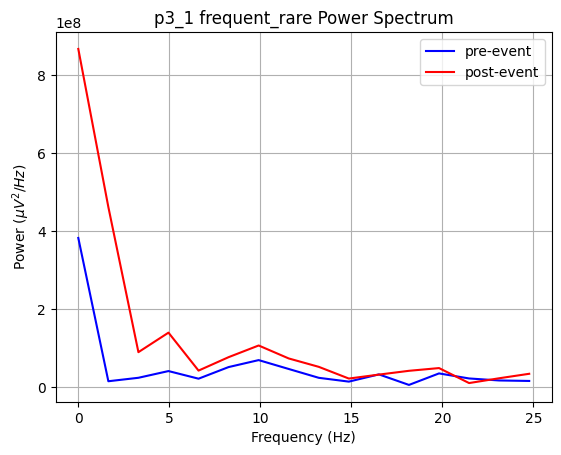

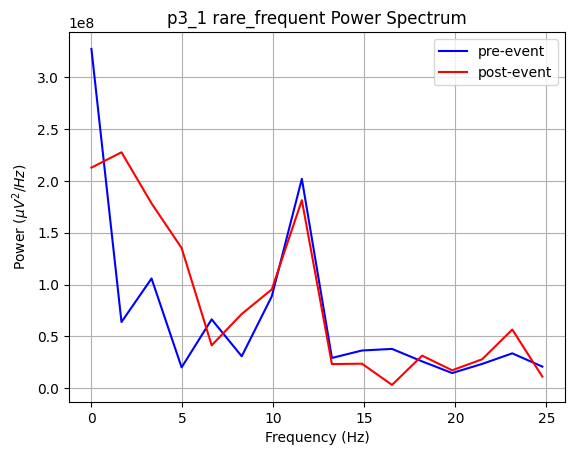

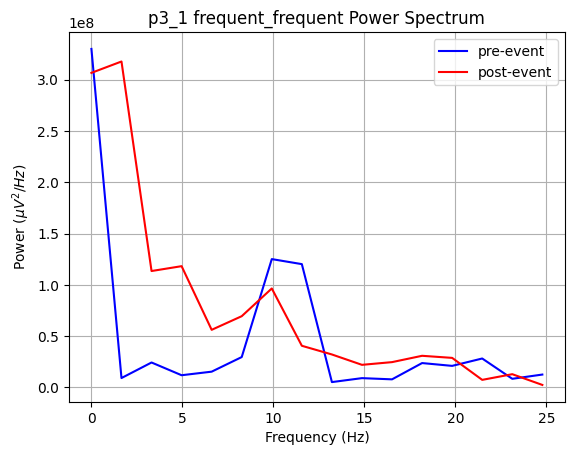

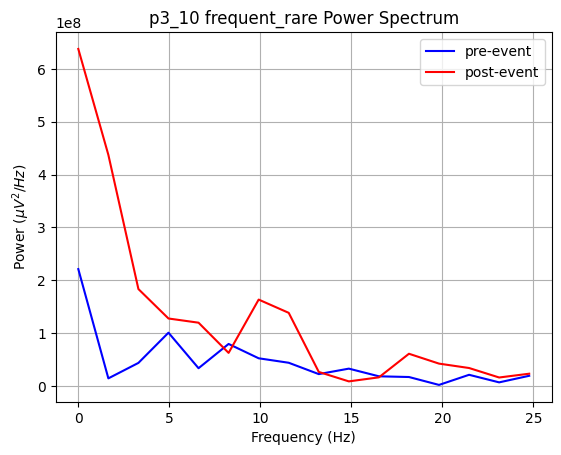

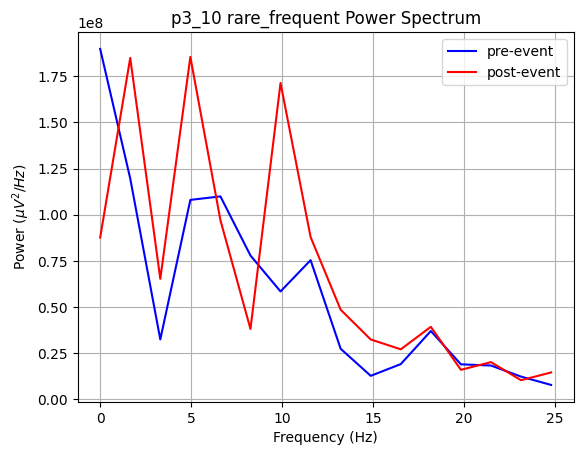

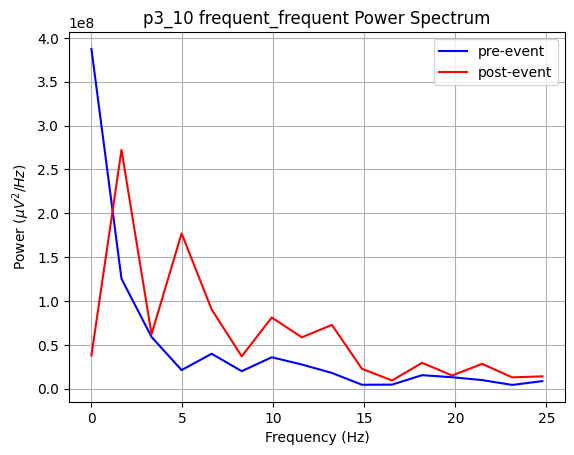

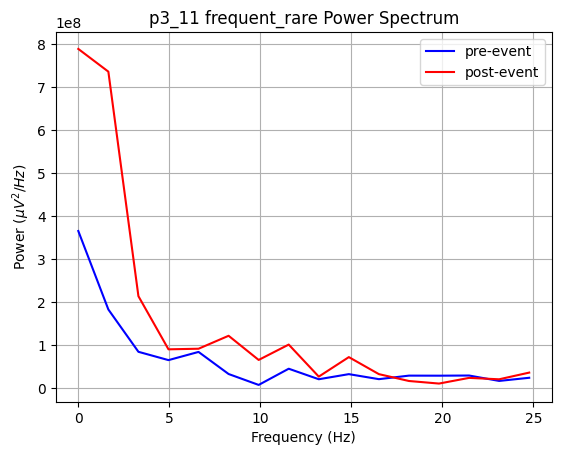

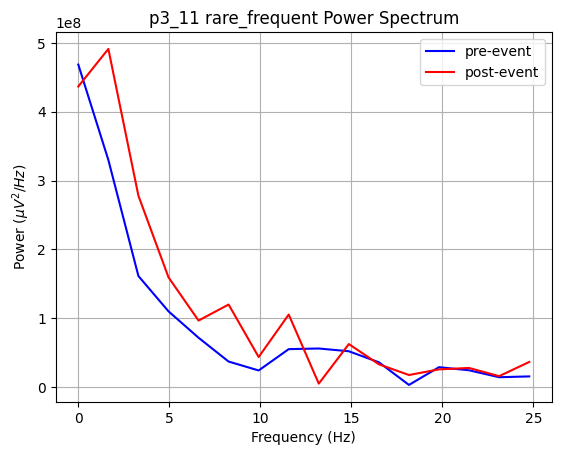

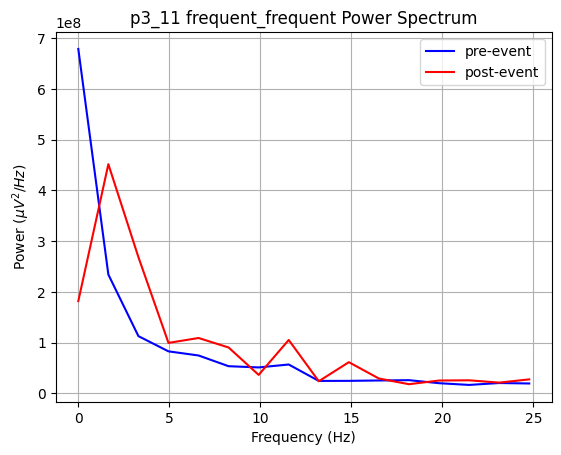

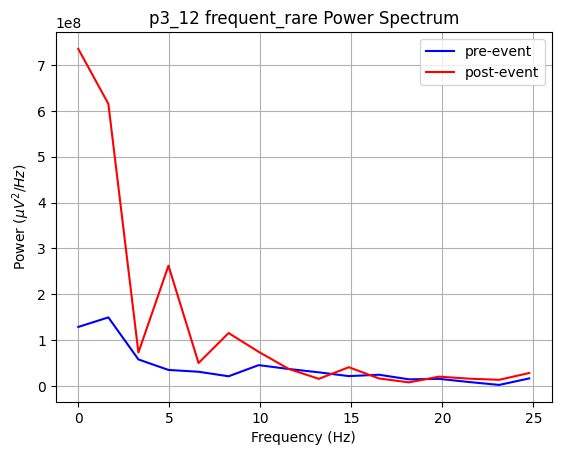

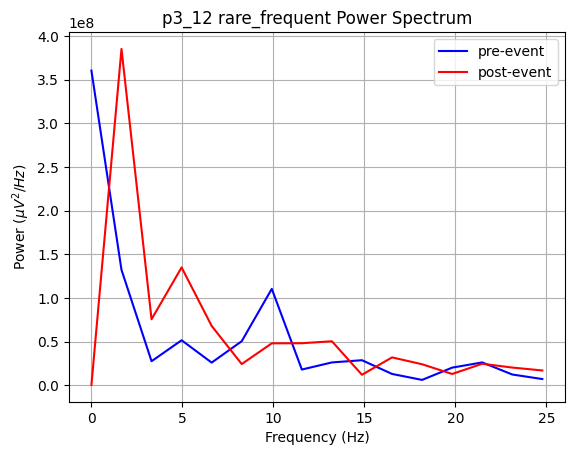

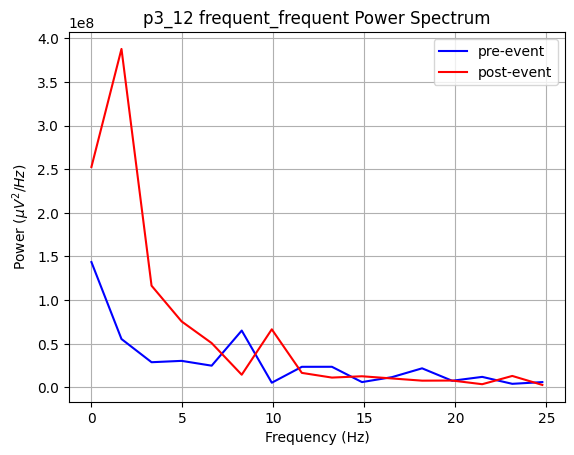

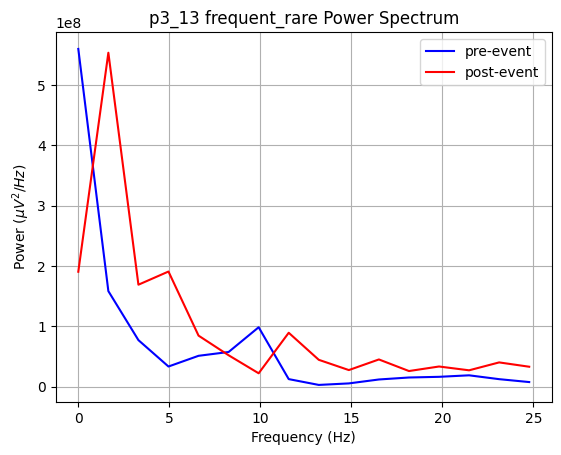

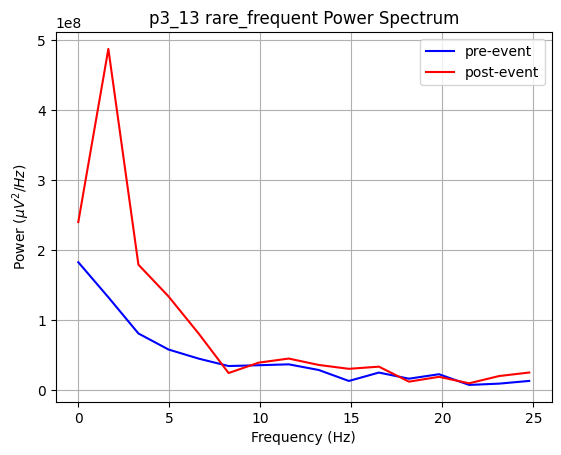

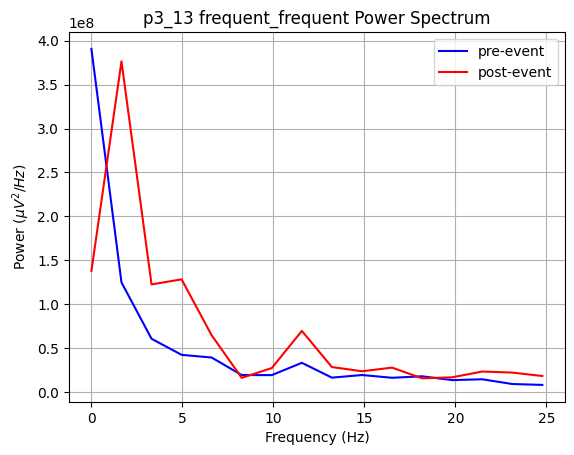

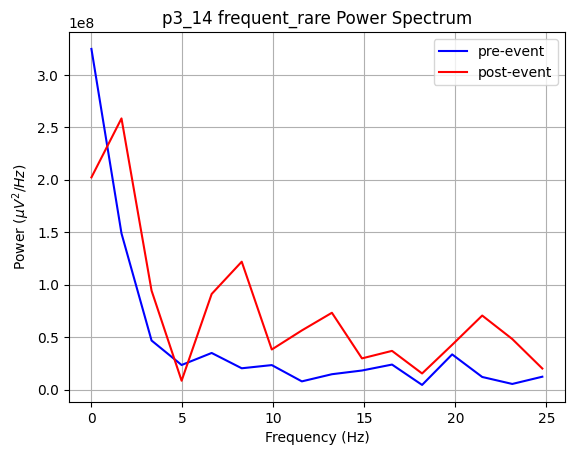

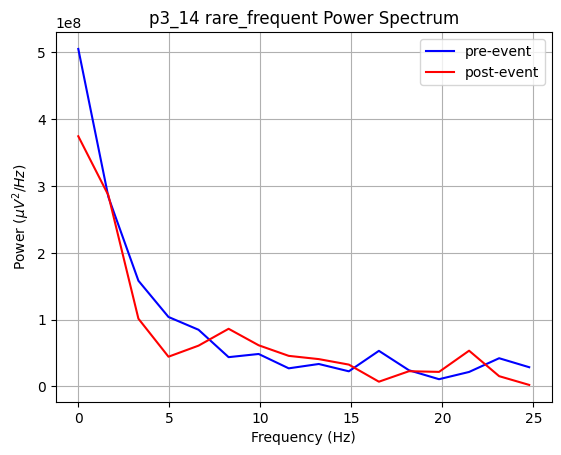

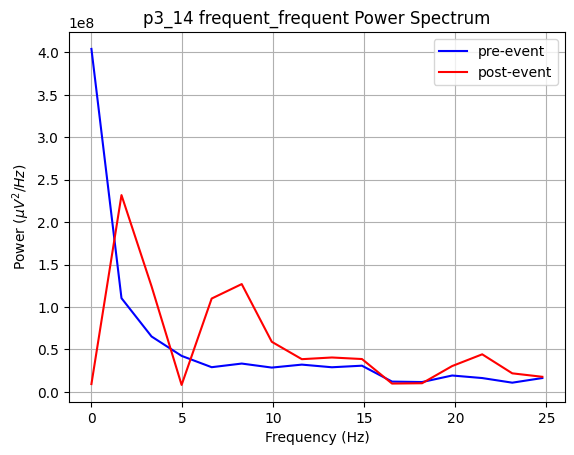

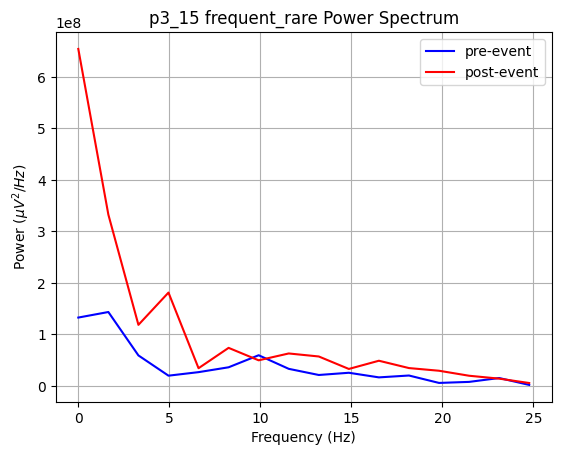

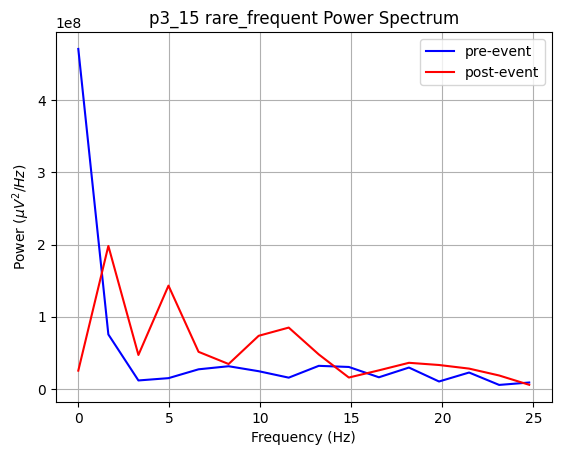

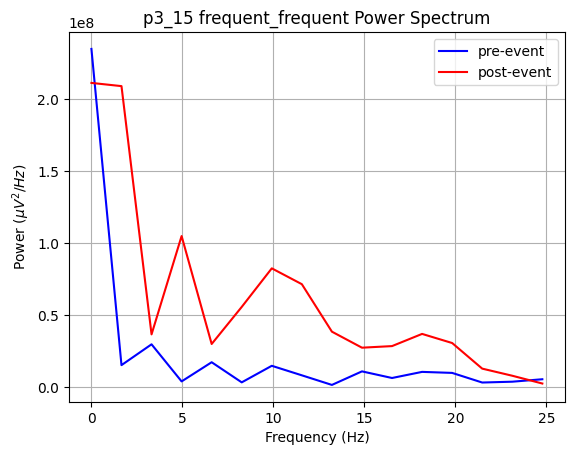

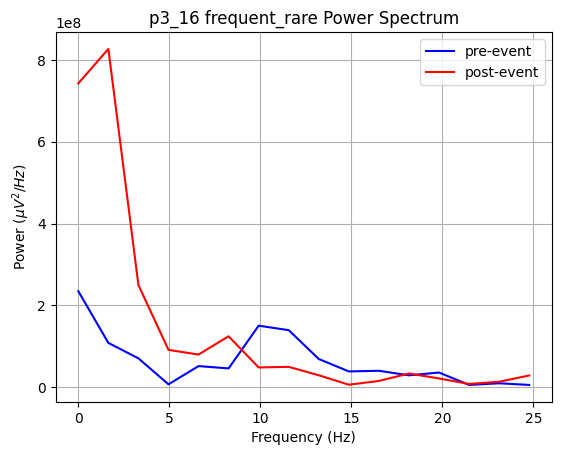

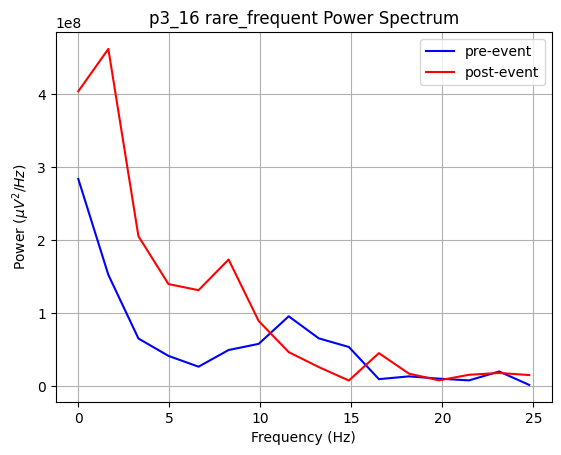

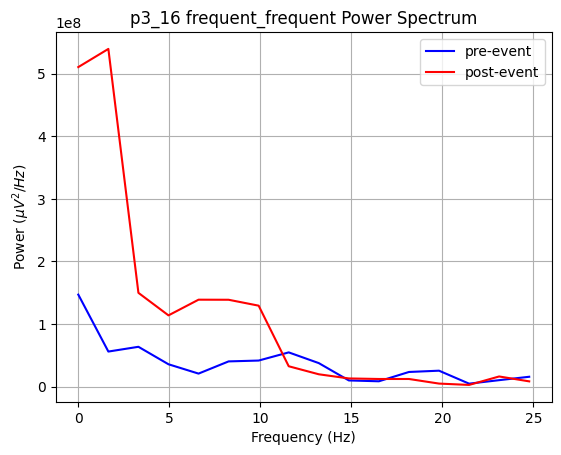

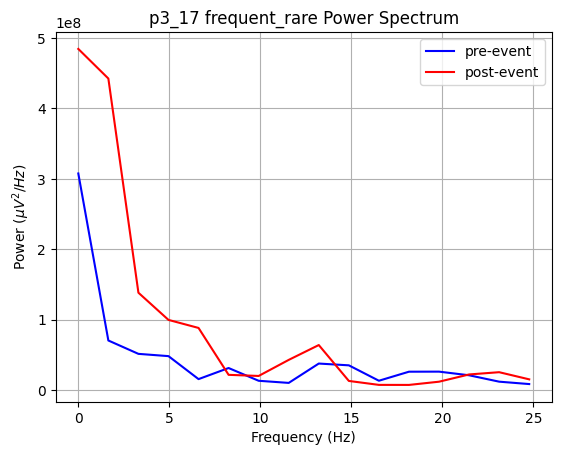

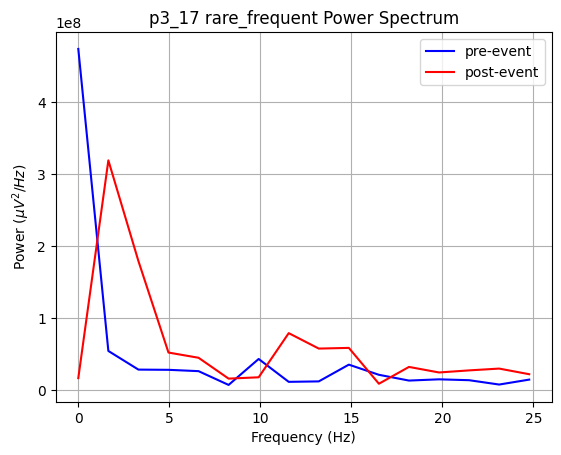

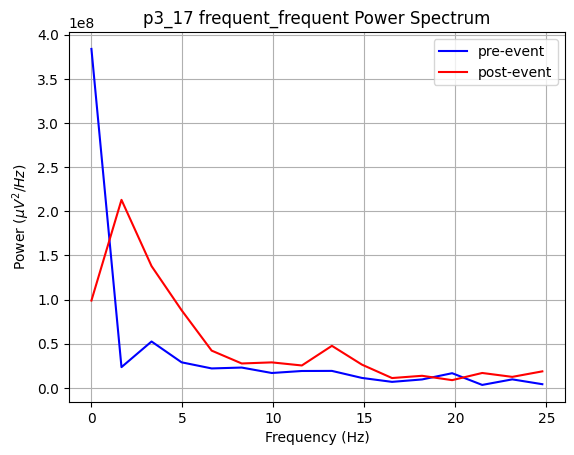

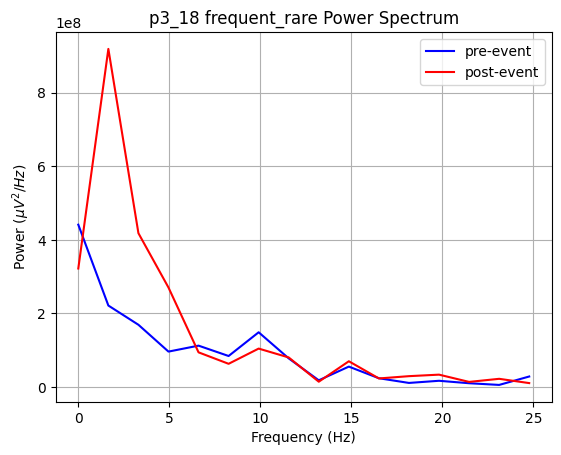

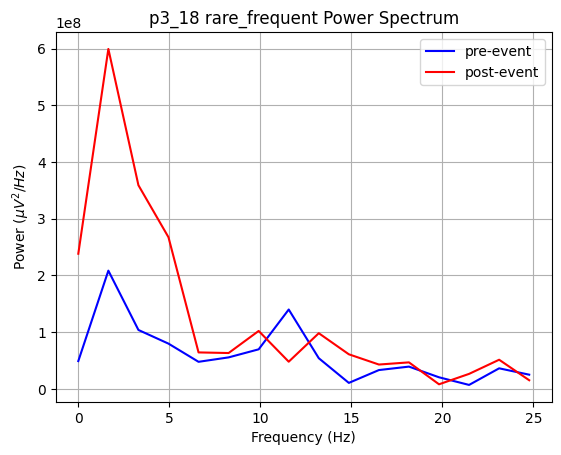

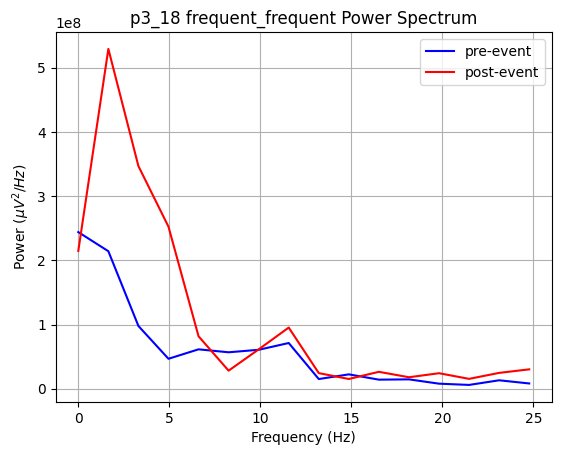

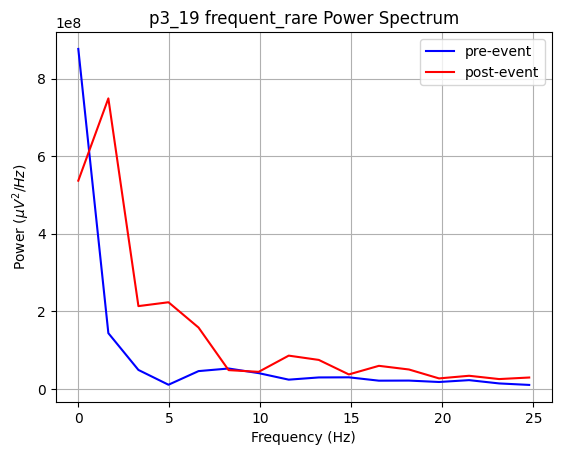

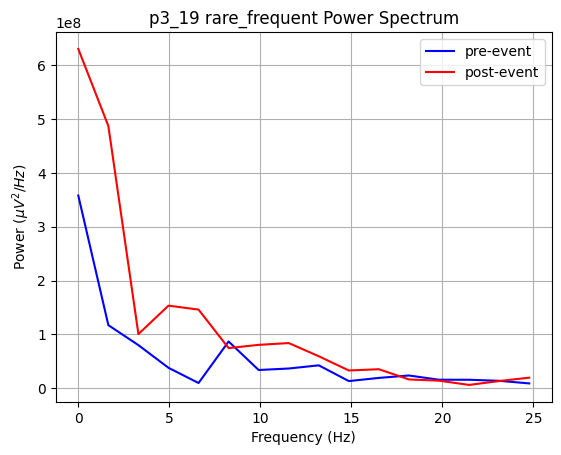

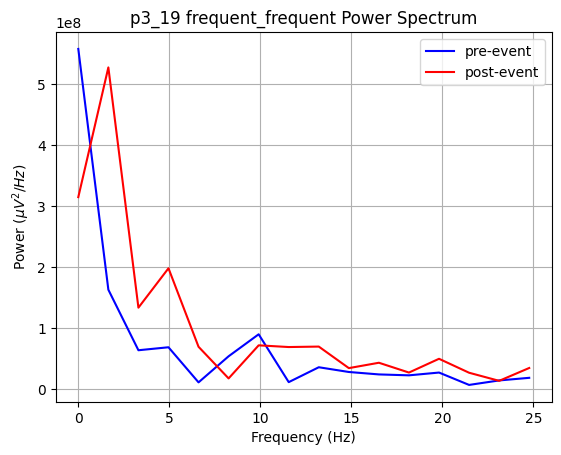

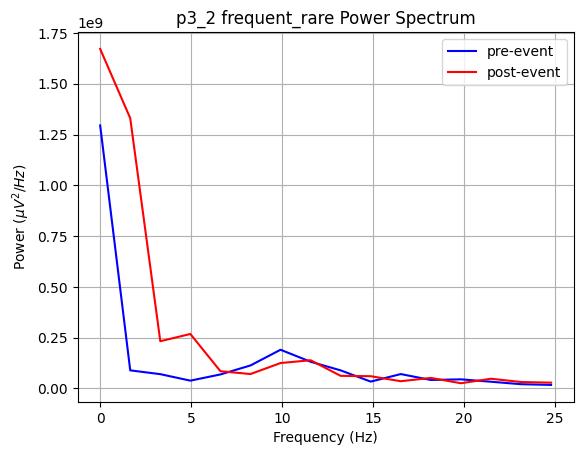

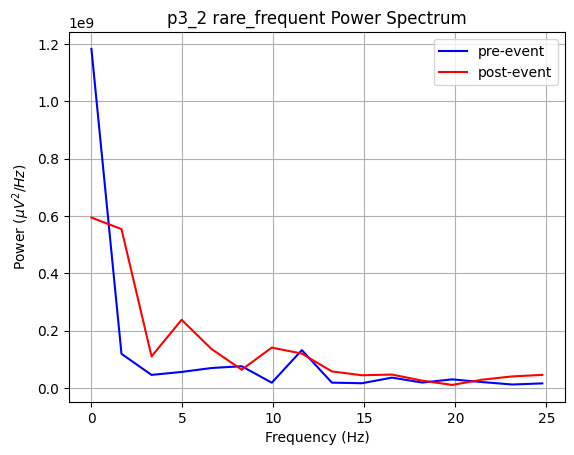

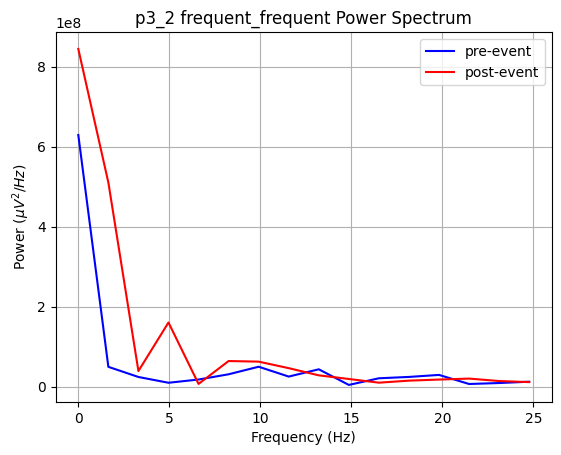

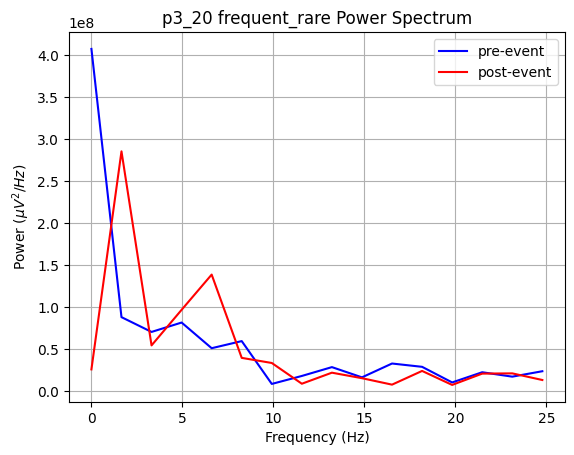

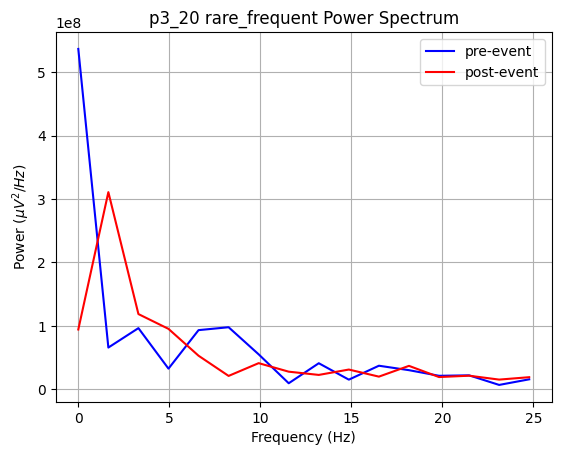

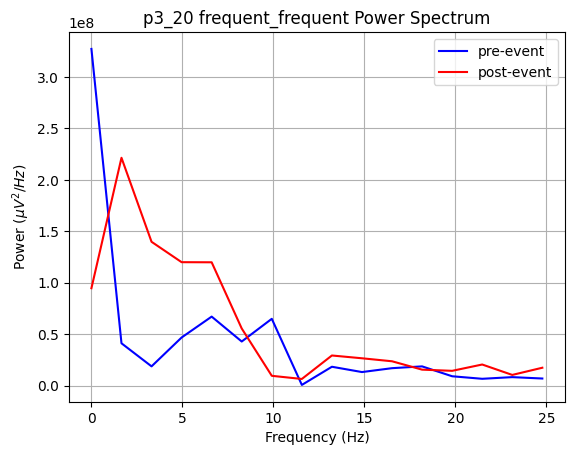

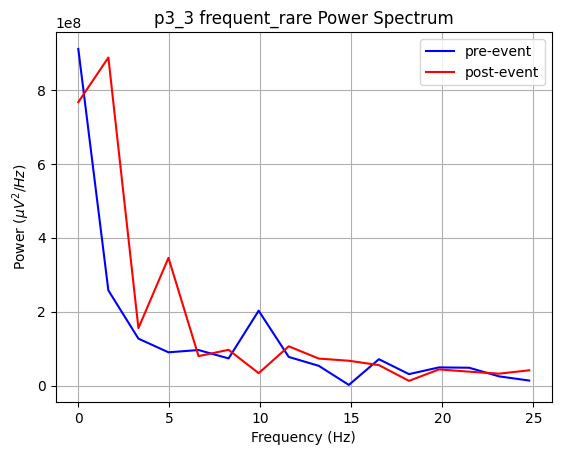

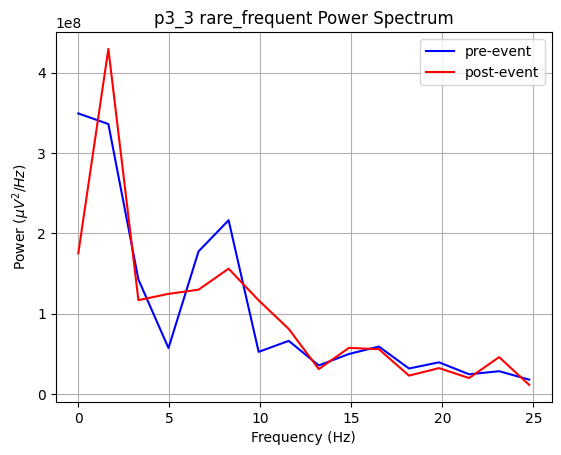

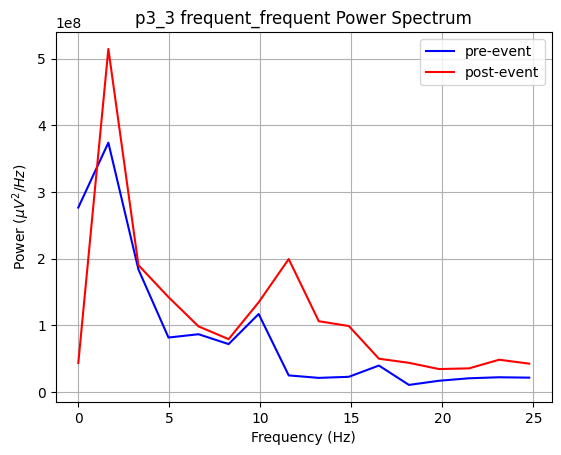

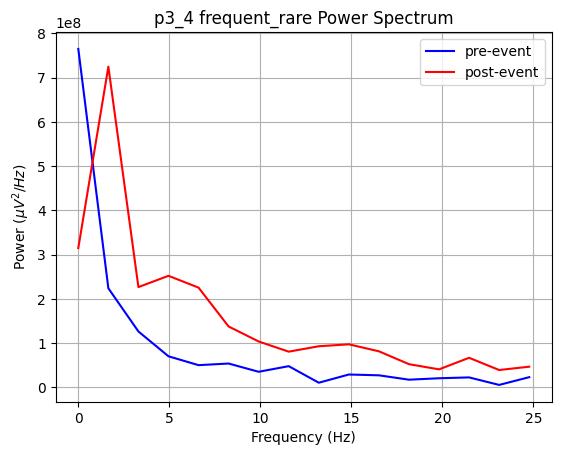

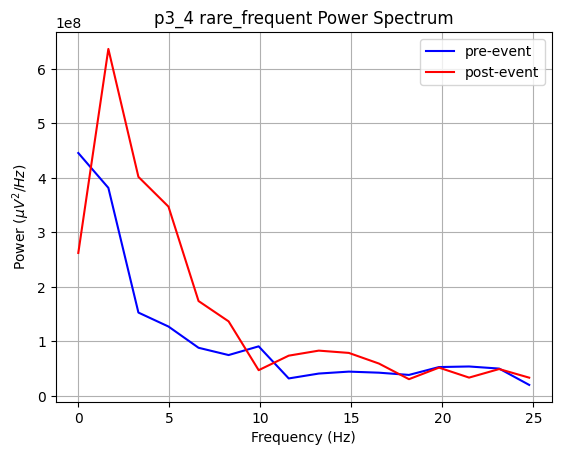

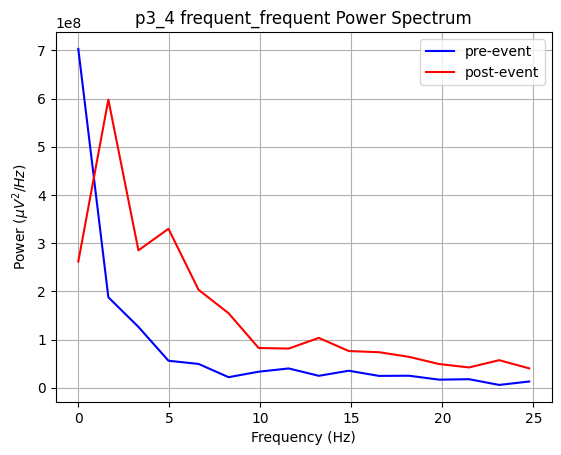

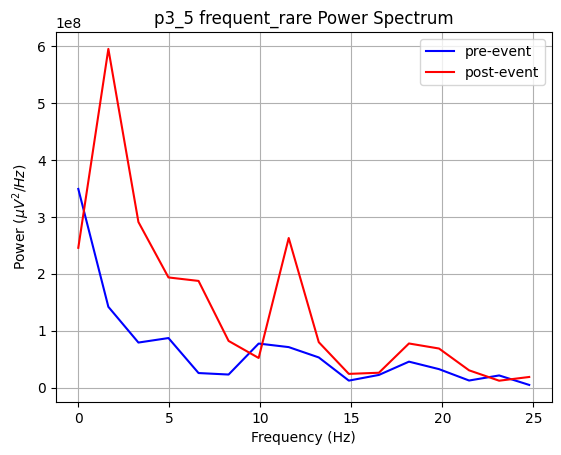

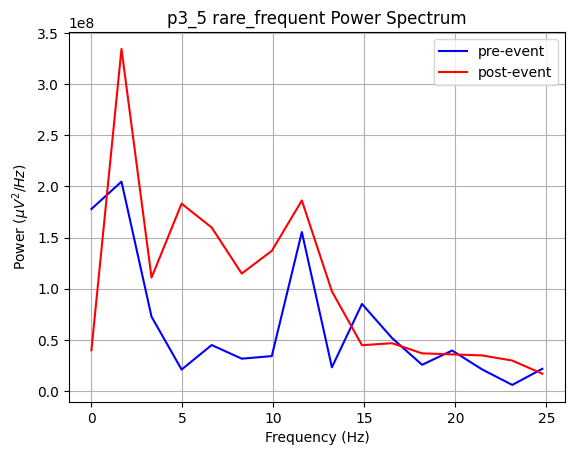

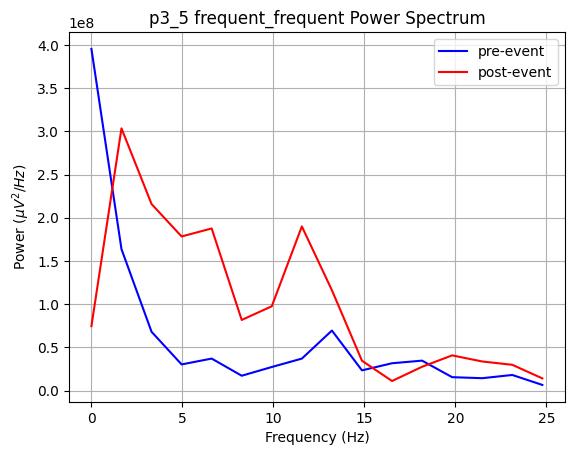

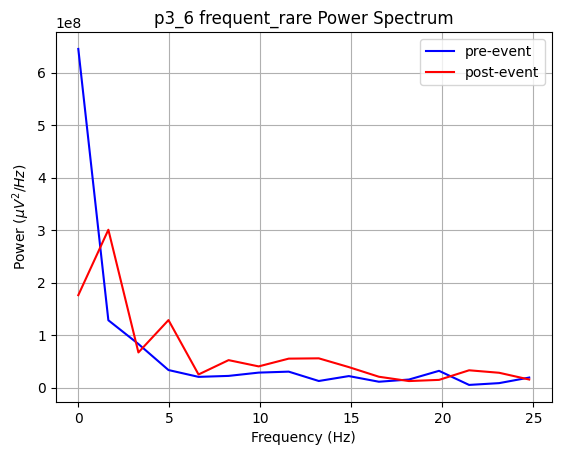

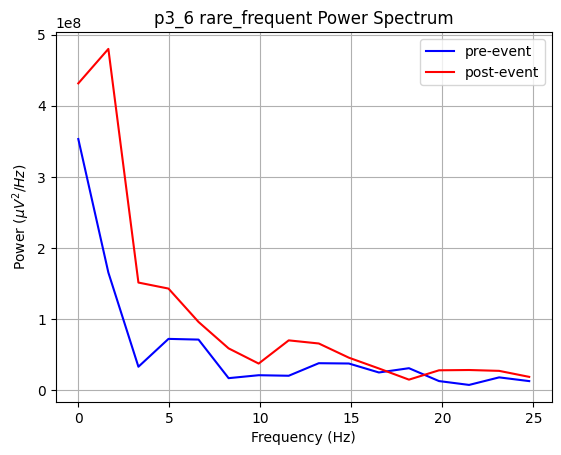

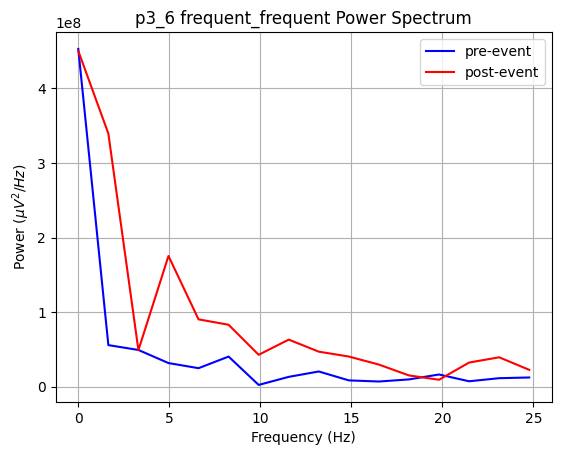

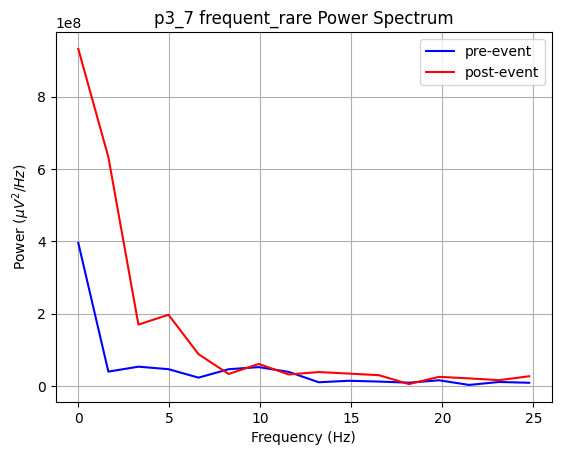

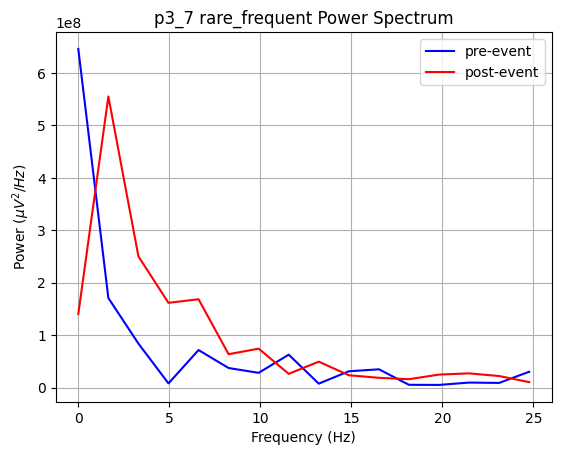

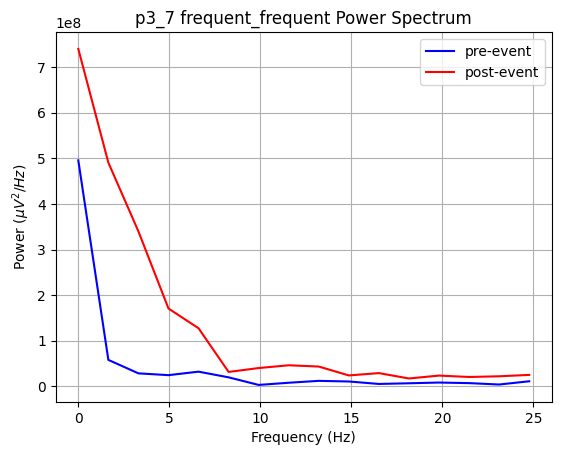

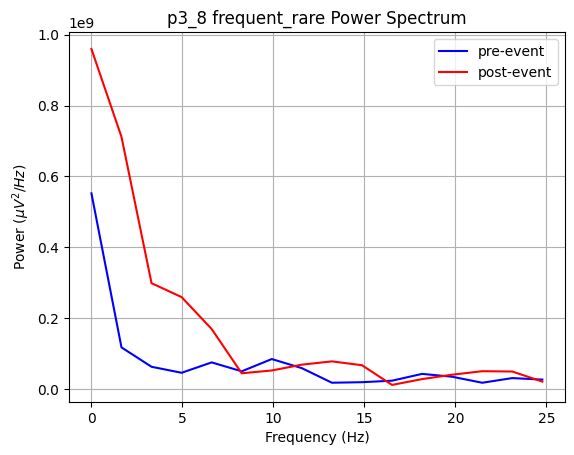

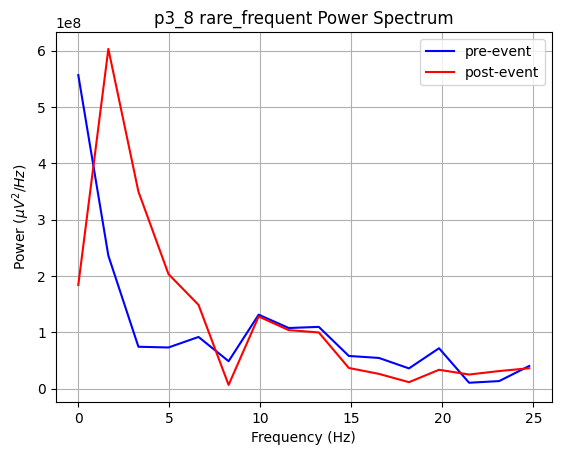

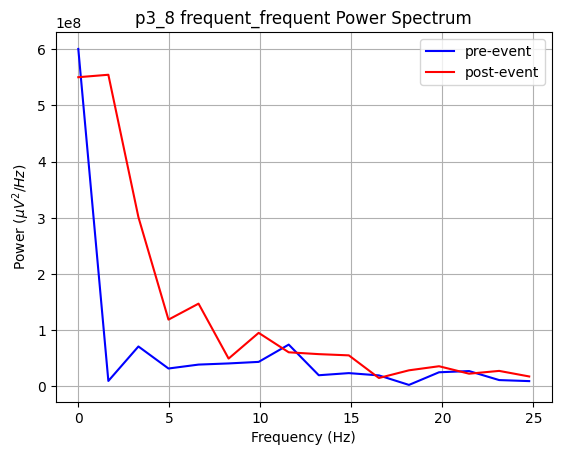

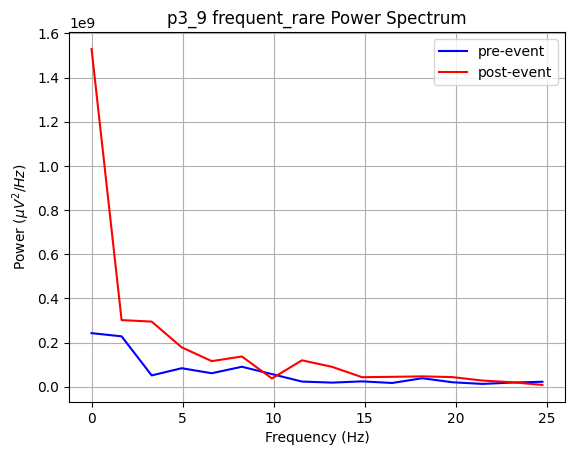

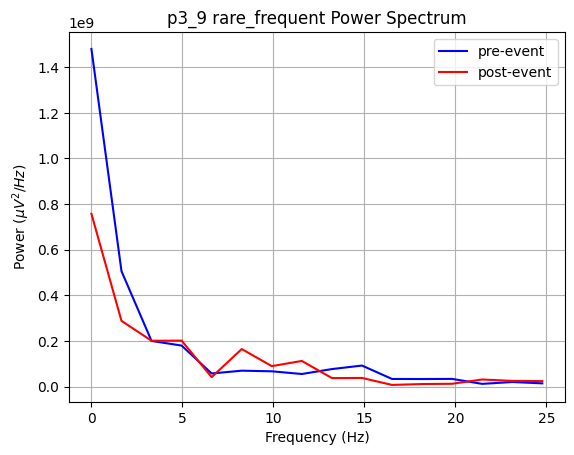

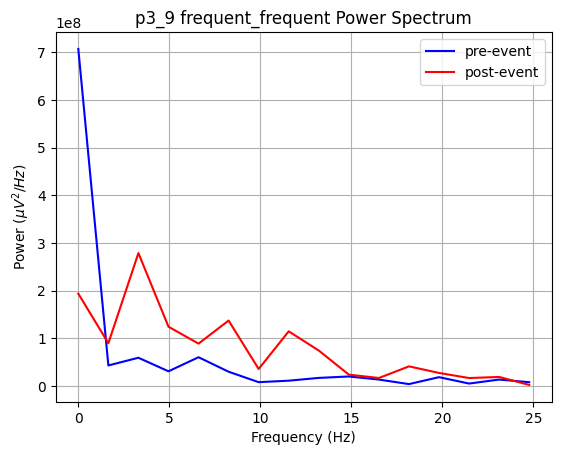

In [13]:
for participant in y_frequencies_dict:
    for condition in y_frequencies_dict[participant]:
        # Access yf_avg_pre (Index 0)
        yf_avg_pre = y_frequencies_dict[participant][condition][0]  

        # Access yf_avg_post (Index 1)
        yf_avg_post = y_frequencies_dict[participant][condition][1]

        # Acess the frequencies (Index 3)
        xf = y_frequencies_dict[participant][condition][3]

        # Acess number of samples
        N = len(xf)

        # Filtering frequencies above 25 hz
        mask = xf[:N // 2] <= 25

        # convert yf_avg_pre and post from volts to microvolts
        scaling_factor = 1e6  # From volts to microvolts
        yf_avg_pre_scaled = yf_avg_pre * scaling_factor**2  # Convert amplitude^2
        yf_avg_post_scaled = yf_avg_post * scaling_factor**2

        plt.plot(xf[:N // 2][mask], yf_avg_pre_scaled[:N // 2][mask], color = 'blue', label = 'pre-event')
        plt.plot(xf[:N // 2][mask], yf_avg_post_scaled[:N // 2][mask],  color = 'red', label = 'post-event')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel(r'Power ($\mu V^2/Hz$)')
        plt.title(f'{participant}'+ ' ' + f'{condition} Power Spectrum')
        plt.legend()
        plt.grid(True)
        plt.show()

In [46]:
conditions = ['frequent_rare', 'rare_frequent', 'frequent_frequent']


for condition in conditions:  
    yf_avg_pre_list = []
    yf_avg_post_list = []
    for participant in y_frequencies_dict:
        # Access yf_avg_pre (Index 0)
        yf_avg_pre = y_frequencies_dict[participant][condition][0]  
        yf_avg_pre_list.append(yf_avg_pre)

        # Access yf_avg_post (Index 1)
        yf_avg_post = y_frequencies_dict[participant][condition][1]
        yf_avg_post_list.append(yf_avg_post)

    # Acess the frequencies (Index 3) (doesnt matter which one we use so just used first index)
    xf = y_frequencies_dict['p3_1']['frequent_rare'][3]

    # Acess number of samples
    N = len(xf)

    # Filtering frequencies above 25 hz
    mask = (xf[:N // 2] <= 25) & (xf[:N // 2] > 2)

    # Take the average across particpants (axis 0 since participants in rows)
    yf_avg_pre_mean =  np.mean(yf_avg_pre_list, axis = 0)
    yf_avg_post_mean =  np.mean(yf_avg_post_list, axis = 0)


    # convert yf_avg_pre and post from volts to microvolts
    scaling_factor = 1e6  # From volts to microvolts
    yf_avg_pre_scaled = yf_avg_pre_mean * scaling_factor**2  # Convert amplitude^2
    yf_avg_post_scaled = yf_avg_post_mean * scaling_factor**2

    plt.plot(xf[:N // 2][mask], yf_avg_pre_scaled[:N // 2][mask], color = 'blue', label = 'pre-event')
    plt.plot(xf[:N // 2][mask], yf_avg_post_scaled[:N // 2][mask],  color = 'red', label = 'post-event')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel(r'Power ($\mu V^2/Hz$)')
    plt.title(f'{condition} Power Spectrum')
    plt.legend()
    plt.grid(True)
    plt.show()

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (20, 3) + inhomogeneous part.

In [ ]:
fg = FOOOFGroup(
    peak_width_limits=[2, 8],
    max_n_peaks= 10,
    min_peak_height=0.3,
    peak_threshold=2.0,
    aperiodic_mode='fixed'
)

freq = y_frequencies_dict['p3_1']['frequent_rare'][0]

IndexError: list index out of range